# Fraudulent credit card transactions

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, fbeta_score, confusion_matrix, precision_recall_curve, accuracy_score
import warnings
warnings.filterwarnings("ignore")

#### This function is to plot the confusion matrix and will be used later

In [2]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Legitimate', 'Fraudulent']); ax.yaxis.set_ticklabels(['Legitimate', 'Fraudulent']) 
    plt.show() 

### Loading data

In [3]:
df = pd.read_csv(r'C:\Users\jeanm\Desktop\Fraudulent transactions\creditcard.csv')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Clarifiying column's names

-  Time: Number of seconds elapsed between this transaction and the first transaction in the dataset
-  V1-V28: Result of a PCA Dimensionality reduction to protect user identities and sensitive features(v1-v28)
-  Amount: Transaction amount
-  Class: 1 for fraudulent transactions, 0 otherwise

### Data wrangling

In [5]:
# Information about the dataset

print('There are ', df.shape[0], 'rows ', 'and ', df.shape[1], 'columns on the dataset')

There are  284807 rows  and  31 columns on the dataset


In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
df[['Time', 'Amount', 'Class']].describe()

,Time,Amount,Class
count,284807.000000,284807.000000,284807.000000
mean,94813.859575,88.349619,0.001727
std,47488.145955,250.120109,0.041527
min,0.000000,0.000000,0.000000
25%,54201.500000,5.600000,0.000000
50%,84692.000000,22.000000,0.000000
75%,139320.500000,77.165000,0.000000
max,172792.000000,25691.160000,1.000000


In [9]:
# Identify and calculate the percentage of the missing values in each attribute

df.isnull().sum()/df.shape[0]*100

Time      0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V14       0.0
V15       0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Amount    0.0
Class     0.0
dtype: float64

In [10]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [11]:
# Calculate number of fraud and legitimate transactions

df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [12]:
# Calculate number of fraud and legitimate transactions (percentages)

df.Class.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

0    99.8%
1     0.2%
Name: Class, dtype: object

It can be seen that the data is clearly imbalanced, it is also shown in the figure below.

### Exploratory data analysis

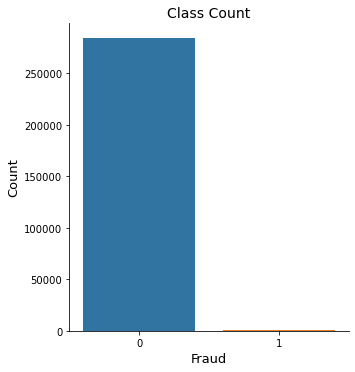

In [13]:
sns.factorplot(x ="Class",kind='count',data=df)
plt.title("Class Count", fontsize = '14')
plt.xlabel("Fraud", fontsize = '13')
plt.ylabel("Count", fontsize = '13')
plt.show()

<AxesSubplot:xlabel='Amount'>

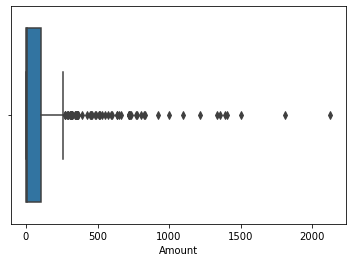

In [14]:
# Boxplot to show the variance in amount spent for fraudulent transactions

sns.boxplot(data = df[df.Class == 1], x = 'Amount')

<AxesSubplot:xlabel='Amount'>

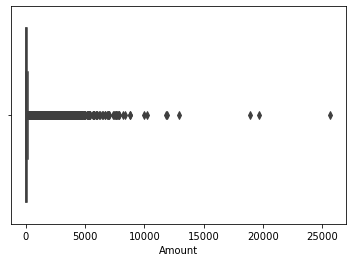

In [15]:
# Boxplot to show the variance in amount spent for legitimate transactions

sns.boxplot(data = df[df.Class == 0], x = 'Amount')

In [16]:
# Channging Time column to hour of the day

timedelta = pd.to_timedelta(df['Time'], unit='s')
df['Time_hour'] = (timedelta.dt.components.hours).astype(int)

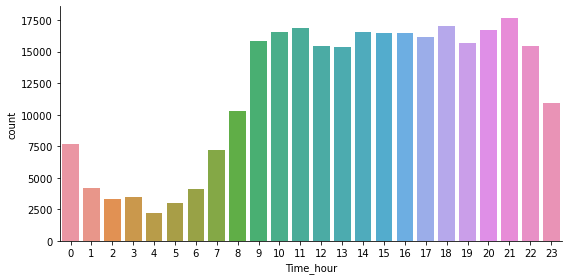

In [17]:
# Displaying at what time the transactions are made

sns.factorplot(x ="Time_hour",kind='count',data=df, size=4, aspect=2)
plt.show()

Clearly, from midnight to 8 am there is not much activity of credit card tranferences

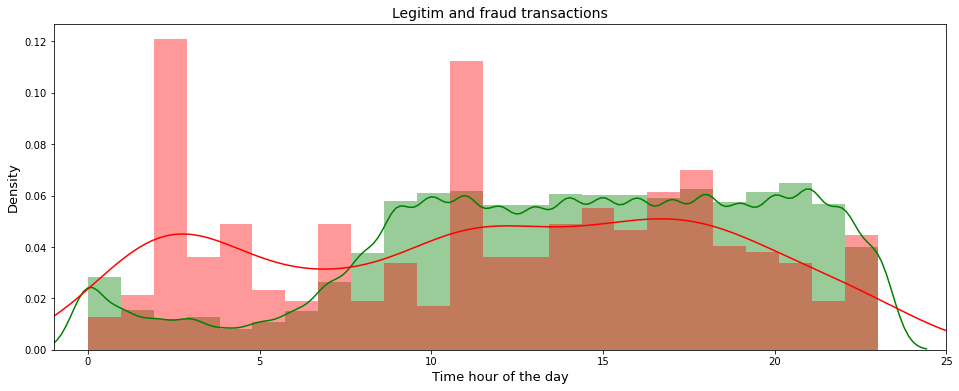

In [18]:
plt.figure(figsize=(16,6))
sns.distplot(df[df['Class'] == 0]["Time_hour"], color='g', bins = 24)
sns.distplot(df[df['Class'] == 1]["Time_hour"], color='r', bins = 24)
plt.title('Legitim and fraud transactions', fontsize=14)
plt.xlabel("Time hour of the day", fontsize = '13')
plt.ylabel("Density", fontsize = '13')
plt.xlim([-1,25])
plt.show()

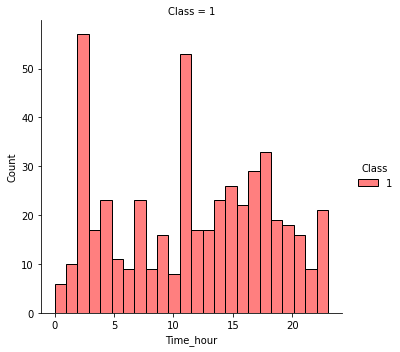

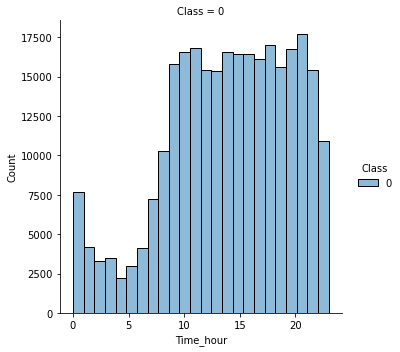

In [19]:
sns.displot(data=df[df.Class == 1], x="Time_hour", hue="Class", col="Class", bins = 24, palette=['red'])
sns.displot(data=df[df.Class == 0], x="Time_hour", hue="Class", col="Class", bins = 24)

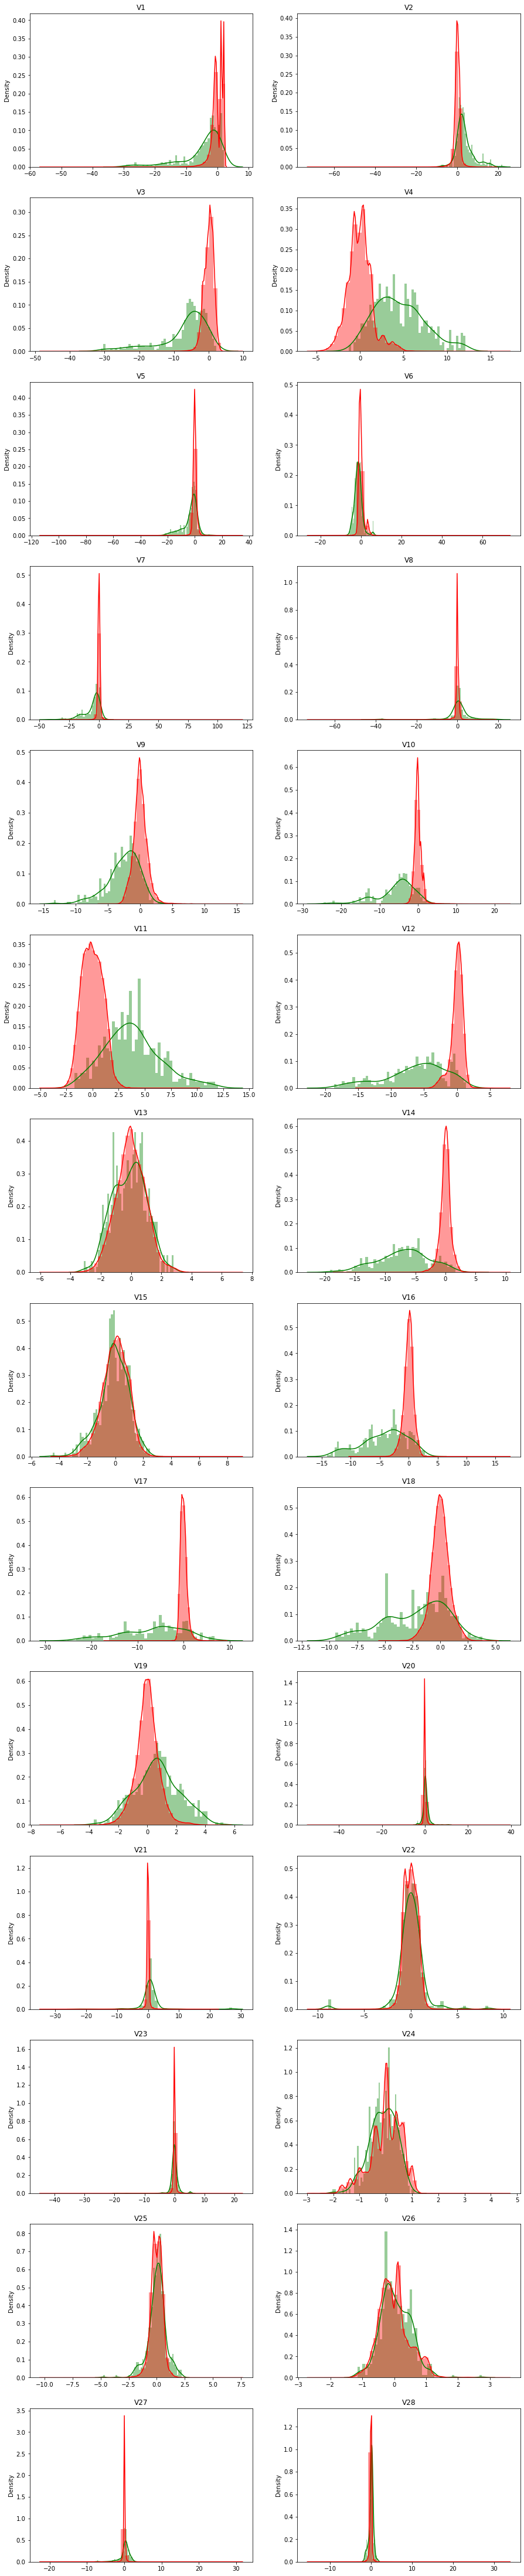

In [20]:
%matplotlib inline

# Analasing the V's features
columns = df.iloc[:,1:29].columns

frauds = df.Class == 1
legitim = df.Class == 0

grid = gridspec.GridSpec(14, 2)
plt.figure(figsize=(15,20*4))

for n, col in enumerate(df[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df[col][frauds], bins = 50, color='g') #Will receive the "semi-salmon" violin
    sns.distplot(df[col][legitim], bins = 50, color='r') #Will receive the "ocean" color
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
plt.show()

This figures gives us an idea about which columns are useful to predict fraudulenct transactions.

In [21]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Time_hour
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0


In [22]:
# Only useful columns are used in the analysis

df_new = df[['Time_hour', 'V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V27', 'Amount', 'Class']]

In [23]:
# Separate dataset between independent and dependent variables

Y = df_new['Class']  # Dependent variable
X = df_new.drop(['Class'], axis=1)   # Independent variables

In [24]:
# Standardize the data

transform = preprocessing.StandardScaler()
df_new = transform.fit_transform(df_new) 
df_new

array([[-2.40693029,  1.6727735 ,  0.97336551, ...,  0.33089162,
         0.24496426, -0.04159898],
       [-2.40693029,  0.1097971 ,  0.31652293, ..., -0.02225568,
        -0.34247454, -0.04159898],
       [-2.40693029,  1.16946849,  0.26823129, ..., -0.13713686,
         1.16068593, -0.04159898],
       ...,
       [ 1.53423047, -2.14320514, -0.39398367, ...,  0.01103672,
        -0.0818393 , -0.04159898],
       [ 1.53423047,  0.46332013,  0.48719238, ...,  0.26960398,
        -0.31324853, -0.04159898],
       [ 1.53423047,  0.46386564, -0.35757   , ..., -0.00598394,
         0.51435531, -0.04159898]])

In [25]:
# Use the function train_test_split to split the data X and Y into training and test data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [26]:
print(X.shape, X_train.shape, X_test.shape)

(284807, 14) (227845, 14) (56962, 14)


In [27]:
activity_count = Y.value_counts()
print(activity_count)

0    284315
1       492
Name: Class, dtype: int64


In [28]:
# Because of imbalanced data: First we will try with using imblearn.under_sampling library 

rus = RandomUnderSampler(sampling_strategy=1)
X_train_rus, Y_train_rus = rus.fit_resample(X_train, Y_train)

### Models

In [43]:
# Logistic regression

lr=LogisticRegression()
# Parameters
parameter_log ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
# GridSearchCV
logreg_cv = GridSearchCV(lr, parameter_log, cv=5)
# Fit it to the data
logreg_cv.fit(X_train_rus, Y_train_rus)
print(logreg_cv.score(X_test, Y_test))

0.9767388785506127


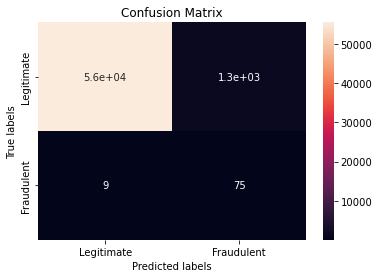

In [44]:
yhat = logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [45]:
print(classification_report(Y_test, yhat))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56878
           1       0.05      0.89      0.10        84

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.54     56962
weighted avg       1.00      0.98      0.99     56962



In [46]:
# Desicion tree classifier
tree = DecisionTreeClassifier()
# Parameters
parameter_tree = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}
# GridSearchCV
tree_cv = GridSearchCV(tree, parameter_tree, cv=5)
# Fit it to the data
tree_cv.fit(X_train_rus, Y_train_rus)
print(tree_cv.score(X_test, Y_test))

0.9611670938520417


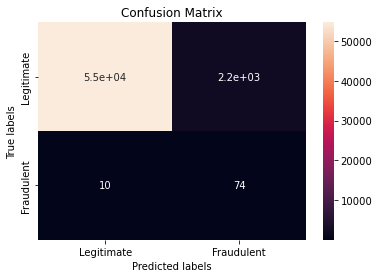

In [47]:
yhat=tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [48]:
print(classification_report(Y_test, yhat))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56878
           1       0.03      0.88      0.06        84

    accuracy                           0.96     56962
   macro avg       0.52      0.92      0.52     56962
weighted avg       1.00      0.96      0.98     56962



It looks like the model predicts too much False Negatives, it could be because of the underfiting

Luckily, literature suggests that SMOTE can help to solve this problem with imbalanced data

Reminder: necessary libraries are installed in the first cell

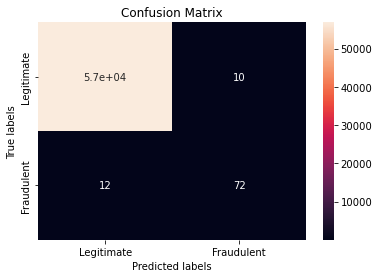

In [33]:
classifier = RandomForestClassifier

# build model with SMOTE imblearn
smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), classifier(random_state=42))

smote_model = smote_pipeline.fit(X_train, Y_train)
smote_prediction = smote_model.predict(X_test)

#Evaluating SMOTE + Random forest
plot_confusion_matrix(Y_test,smote_prediction)

In [34]:
print(classification_report(Y_test, smote_prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56878
           1       0.88      0.86      0.87        84

    accuracy                           1.00     56962
   macro avg       0.94      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962



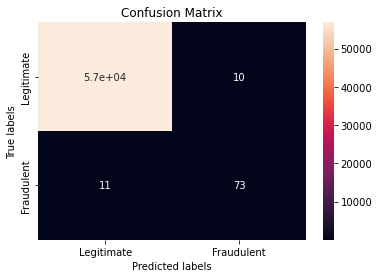

In [35]:
classifier2 = ExtraTreesClassifier

# build model with SMOTE imblearn
smote_pipeline2 = make_pipeline_imb(SMOTE(random_state=4), classifier2(random_state=42))

smote_model2 = smote_pipeline2.fit(X_train, Y_train)
smote_prediction2 = smote_model2.predict(X_test)

#Evaluating SMOTE + Extra Tree
plot_confusion_matrix(Y_test,smote_prediction2)

In [36]:
print(classification_report(Y_test, smote_prediction2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56878
           1       0.88      0.87      0.87        84

    accuracy                           1.00     56962
   macro avg       0.94      0.93      0.94     56962
weighted avg       1.00      1.00      1.00     56962



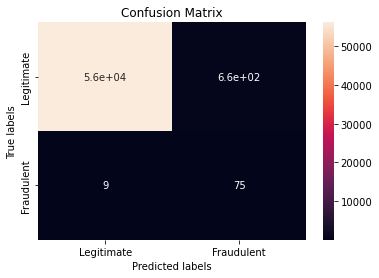

In [37]:
classifier3 = GradientBoostingClassifier

# build model with SMOTE imblearn
smote_pipeline3 = make_pipeline_imb(SMOTE(random_state=4), classifier3(random_state=42))

smote_model3 = smote_pipeline3.fit(X_train, Y_train)
smote_prediction3 = smote_model3.predict(X_test)

#Evaluating SMOTE + Gradiant Boosting
plot_confusion_matrix(Y_test,smote_prediction3)

In [38]:
print(classification_report(Y_test, smote_prediction3))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56878
           1       0.10      0.89      0.18        84

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.59     56962
weighted avg       1.00      0.99      0.99     56962



## Conclusion

Different models were tested and their metrics help to choose the best model for this case.

After analyzing the data, it was clearly seen that it is highly imbalanced. Therefore, techniques to deal with this were applied.

The synthetic minority oversampling technique (SMOTE) showed to be the most accurate one to deal with imabalanced data. 

SMOTE + Random forest and SMOTE + Extremely Randomized Trees Classifier were the ones with the best scores in the metrics.

Although the F1-score and precision metrics are the same for the last two models mentioned, it can be concluded that the SMOTE + Extremely Randomized Trees Classifie is the best model for this case because its recall score was higher.